In [117]:
# basics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.stats import unitary_group
# penny
import pennylane as qml
from pennylane.transforms import compile
from pennylane.math import fidelity_statevector as fidelity_penny
# qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Gate
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_circuit_layout, circuit_drawer
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import state_fidelity as fidelity_qiskit
from math import pi
import copy

In [118]:
def to_qiskit(dict_elem): # pennylane to qiskit using the dictionary to map
    name = dict_elem['name']
    wires = dict_elem['wires']
    params = dict_elem['params']

    gate_map = {
        'Hadamard': lambda : qc.h(wires[0]),
        'PauliX': lambda: qc.x(wires[0]),
        'CNOT': lambda: qc.cx(wires[0], wires[1]),
        'CZ': lambda: qc.cz(wires[0], wires[1]),
        'RY': lambda: qc.ry(params[0], wires[0]),
        'QubitUnitary': lambda: qc.append(UnitaryGate(params[0]), wires),
        'U1': lambda: qc.p(params[0], wires[0]),
        'U2': lambda: qc.u(pi/2, params[0], params[1], wires[0])
    }

    if name in gate_map:
        gate_map[name]()
    else:
        raise ValueError(f"Unsupported gate: {name}")

In [119]:
def summary_qiskit(qc):
    counts = {"1-qubit": 0, "2-qubit": 0}
    for inst in qc.data:
        if isinstance(inst.operation, Gate):  
            num_qubits = len(inst.qubits)
            if num_qubits == 1:
                counts["1-qubit"] += 1
            elif num_qubits == 2:
                counts["2-qubit"] += 1
    return [qc.num_qubits, qc.size(), counts['1-qubit'], counts['2-qubit'], qc.depth()]

In [120]:
[ds] = qml.data.load("ketgpt")

In [121]:
seed = random.randint(0,1000)

gate_name = []
gate_info = []
for op in ds.circuits[seed]:
    gate_info.append({
        "name": op.name,
        "wires": [int(w) for w in op.wires],
        "params": op.parameters,
    })

gate_info[:3]

[{'name': 'U2', 'wires': [0], 'params': [0.0, 0.0]},
 {'name': 'U2', 'wires': [0], 'params': [0.0, 0.0]},
 {'name': 'U2', 'wires': [1], 'params': [0.0, 0.0]}]

In [122]:
qc = QuantumCircuit(ds.n_qubits[seed])
for dict_elem in gate_info:
    to_qiskit(dict_elem)

print(summary_qiskit(qc))

[37, 294, 207, 87, 40]


In [123]:
# normal pennylane circuits
# which consist of PauliX, CNOT, CZ, Hadamard, QubitUnitary, U1, U2, and RY
# extendable for your purposes

n_wires = 13
dev = qml.device("default.qubit", wires=n_wires)

# Random 2x2 unitary for QubitUnitary
U = unitary_group.rvs(2)

@qml.qnode(dev)
def test_circuit():
    # Layer 1: Redundant single-qubit gates
    for i in range(n_wires):
        qml.PauliX(i)
        qml.PauliX(i)
        qml.Hadamard(i)
        qml.RY(np.pi / 4, wires=i)
        qml.RY(np.pi / 8, wires=i)
        qml.U1(np.pi / 3, wires=i)  # U1 equivalent
        qml.U2(np.pi / 4, np.pi / 2, wires=i)

    # Layer 2: Entanglement via CNOTs in a ring
    for i in range(n_wires - 1):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[n_wires - 1, 0])  # Close the ring

    # Layer 3: Inject QubitUnitary into select wires
    for i in range(0, n_wires, 3):
        qml.QubitUnitary(U, wires=i)

    # Layer 4: More redundancy
    for i in range(n_wires):
        qml.PauliX(i)
        qml.RY(np.pi / 2, wires=i)
        qml.Hadamard(i)
        qml.Hadamard(i)
        qml.U1(np.pi / 6, wires=i)
        qml.U2(np.pi / 2, np.pi / 3, wires=i)

    # Layer 5: More CNOTs for chaos
    for i in range(0, n_wires - 2, 2):
        qml.CNOT(wires=[i, i + 2])

    return qml.state()

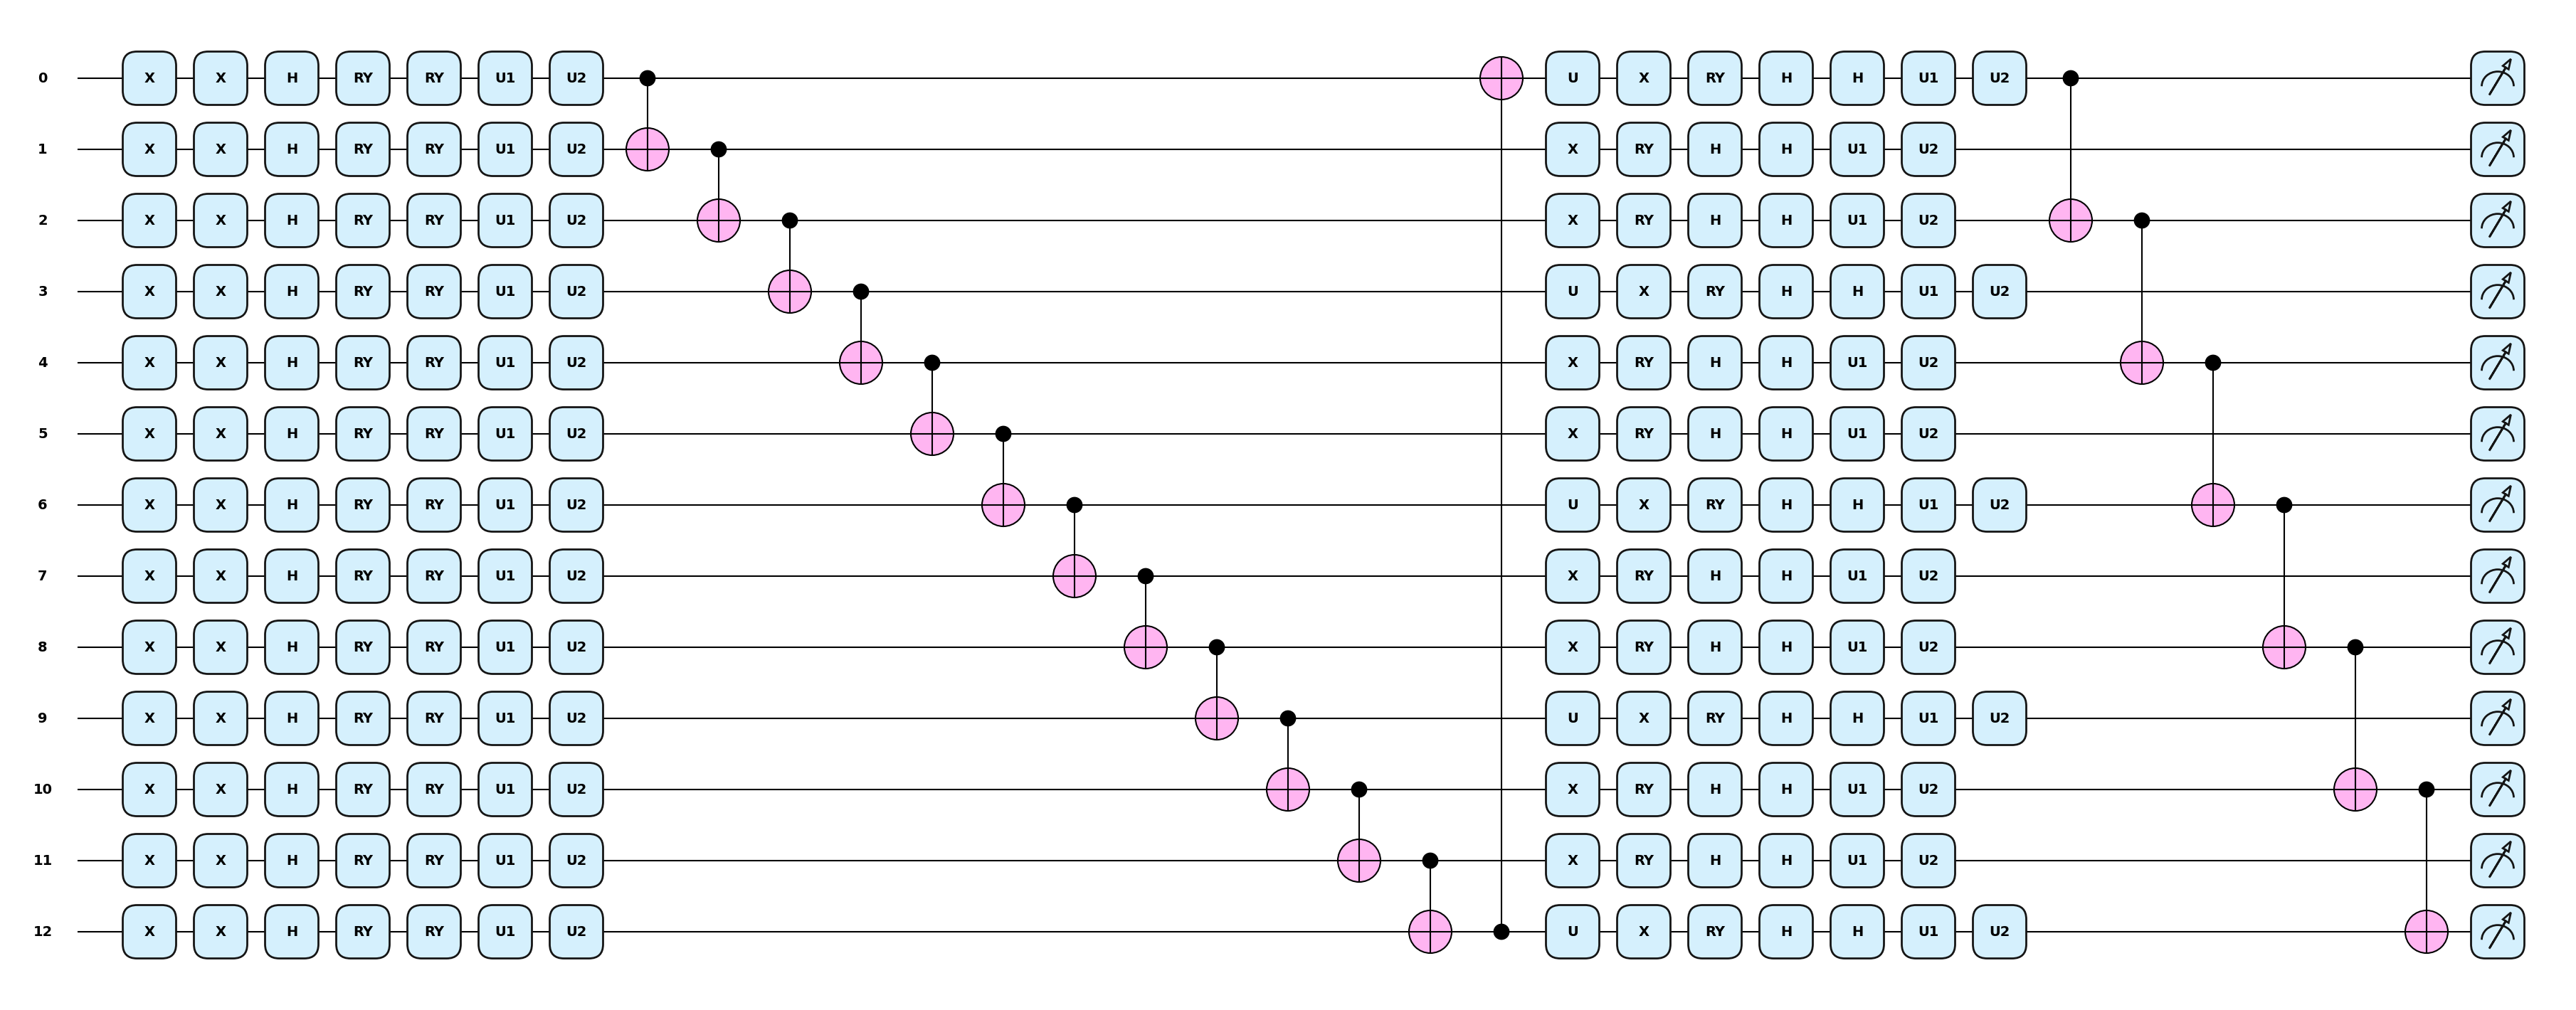

In [124]:
qml.draw_mpl(test_circuit, style='pennylane')()
plt.show()

In [125]:
def extract_gate_info_from_qnode(qnode):
    """Extracts gate info from a QNode by tracing its quantum function."""
    quantum_fn = qnode.func

    with qml.tape.QuantumTape() as tape:
        quantum_fn()

    gate_info = []
    for op in tape.operations:
        safe_params = []
        for p in op.parameters:
            try:
                safe_params.append(float(p))  
            except (TypeError, ValueError):
                safe_params.append(np.array(p).tolist()) 

        gate_info.append({
            "name": op.name,
            "wires": list(op.wires),
            "params": safe_params
        })

    return gate_info

In [126]:
extract_gate_info_from_qnode(test_circuit)[:3]

[{'name': 'PauliX', 'wires': [0], 'params': []},
 {'name': 'PauliX', 'wires': [0], 'params': []},
 {'name': 'Hadamard', 'wires': [0], 'params': []}]

In [127]:
gate_info = extract_gate_info_from_qnode(test_circuit)[:3]

qc = QuantumCircuit(ds.n_qubits[seed])
for dict_elem in gate_info:
    to_qiskit(dict_elem)

print(summary_qiskit(qc))

[37, 3, 3, 0, 3]
